# Report

### The learning algorithm & model architectures

**Deep Q-Network**

The learning algorithm used is called a [Deep Q-Network](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (or DQN). This algorithm was specifically developed to work with video games.

At the heart of the algorithm is a deep neural network used as a function approximator. The neural network in this learning algorithm is a multi layer perceptron (MLP) with two fully connected layers, each with 64 nodes.

The neural network produces as its output a vector of action values, where the largest value corresponds to the best action taken by the agent. Depending on how the algorithm is set up, the action taken can always correspond to the maximum value in the vector, or the action choice can be determined stochastically.

When initialized, the neural network weights are randomly generated and, as a result, the actions taken by the agent are equally as random. However, as a reinforcement signal, the change in reward/score is fed back at each time step, and over time, the network weights are altered and the network's ability to approximate the function improves. This leads to better actions at each state, and the agent's score improves over time.

The Deep Q-Network learning algorithm also makes use of Experience Replay and Fixed Q-Targets.

**Experience Replay**  

In order to effectively learn about the environment it is operating in, the agent needs to explore the state space and see how the states and actions affect the rewards it receives.

Every action taken by an agent affects the next state in some way, so a series of experience tuples can be highly correlated to each other. A naive Q-learning algorithm that learns from each of the the experience tuples that are generated while it interacts with the environment in sequential order can become swayed by the effects of the high correlations and can cause the action values to oscillate or diverge out of control, hindering its ability to make smart decisions.

Experience replay is designed to counter this issue. A replay buffer is populated as the agent interacts with the environment, and during learning, a small batch of experiences from the buffer is sampled at random (not in sequence), allowing the agent to recall states and actions taken in the past.

By sampling from a replay buffer, the agent is able to learn a more robust policy by experiencing individual tuples multiple times, recalling rare states, and not being swayed by highly correlated sequences of state, actions and rewards. This essentially has the effect of reducing the reinforcement learning problem into a supervised learning problem, where the samples become the labels used to train the neural network.

**Fixed Q-Targets**

Q-learning is a form of temporal difference (TD) learning, where the goal is to reduce the difference between the TD target and the currently predicted q-value (also known as the TD error).

The TD target acts as a replacement for the true q-value function, which is not known. However, this creates an issue:

While the true value function q is *not* dependent on the function approximation or the parameters, the TD target *is*. Technically, this is not mathematically correct, but is not so much of an issue because every update results in a very small change to the parameters (set by the learning rate), which is generally in the right direction.

This is also less of a concern when q-values are stored separately for each state-action pair in a q-table or dictionary, but can have a profound impact on the algorithm's ability to learn when function approximation is used. This is because all q-values are intrinsically tied together through the function parameters.

The issue, therefore, is that there is a high correlation between the TD target and the parameters that the algorithm is always updating, creating an issue of trying to predict a moving target. Doing so creates a great deal of noise and can cause the algorithm to diverge or fall into an oscillating pattern.

To counter this, the TD target's position is decoupled from the agent's actions, providing a much more stable learning environment with fewer 'moving parts'. It is achieved by temporarily fixing the function parameters that are used to generate the target value; in practice, the weights/parameters are copied and these fixed copies are used to generate targets, while the original set of weights are updated for a certain number of learning steps.

After these steps have been completed, the updated weights are copied over, and learning can continue again with these new - temporarily fixed - weights.

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

In [2]:
def extract_info_from_file_name(s):
    
    d = {}
    items = s.replace('.csv', '').split(',')
    for item in items:
        if '__' not in item:
            d['timestamp'] = item
        else:
            k, v = item.split('__')
            d[k] = v
            
    return d

### Load all runs

In [3]:
runs_dir = '../runs'
runs = os.listdir(runs_dir)
runs = [item for item in runs if '.' not in item] # remove the markdown file

In [4]:
runs_info = []
runs_data = []

In [5]:
counter = 0
for run in runs:
    run_dir = os.path.join(runs_dir, run)
    files = os.listdir(run_dir)
    
    if len(files) > 0:
        try:
            csv_file_name = [f for f in os.listdir(run_dir) if '.csv' in f][0]

            # extract the summary information
            info_dict = extract_info_from_file_name(csv_file_name)
            info_dict['id'] = counter
            runs_info.append(info_dict)

            # save scores data to df
            df = pd.read_csv(os.path.join(run_dir, csv_file_name))
            df.rename(columns={'episode_score':counter}, inplace=True)
            df.set_index('episode_number', inplace=True)
            runs_data.append(df)

            counter += 1
            
        except:
            pass

In [6]:
summary_data = pd.DataFrame(runs_info)
score_data = pd.concat(runs_data, sort=False, axis=1, ignore_index=True)

for col in ['eps_decay', 'eps_end', 'eps_start', 'gamma', 'lr', 'tau']:
    summary_data[col] = summary_data[col].astype(float)
    
for col in ['max_t', 'n_episodes', 'solved_in', 'update_every', 'batch_size', 'buffer_size']:
    summary_data[col] = summary_data[col].astype(int)

### Summary of scores

In [7]:
display(summary_data.sort_values(by='solved_in'))

,batch_size,buffer_size,eps_decay,eps_end,eps_start,gamma,id,lr,max_t,n_episodes,solved_in,tau,timestamp,update_every
0,64,100000,0.995,0.01,1.0,0.99,0,0.0005,1000,500,0,0.001,201807211007,3
6,64,100000,0.995,0.01,1.0,0.99,6,0.0005,1000,500,0,0.001,201820211020,2
9,64,100000,0.995,0.01,1.0,0.99,9,0.0005,1000,500,0,0.001,201832211032,1
2,64,100000,0.600,0.01,1.0,0.99,2,0.0005,1000,500,140,0.001,201810221622,3
12,64,100000,0.600,0.01,1.0,0.99,12,0.0005,1000,500,157,0.001,201847221147,2
4,64,100000,0.600,0.01,1.0,0.99,4,0.0005,1000,500,179,0.001,201817212117,4
10,64,100000,0.800,0.01,1.0,0.99,10,0.0005,1000,500,180,0.001,201834212034,4
15,64,100000,0.700,0.01,1.0,0.99,15,0.0005,1000,500,201,0.001,201859212059,4
7,64,100000,0.500,0.01,1.0,0.99,7,0.0005,1000,500,215,0.001,201829212129,4
1,64,100000,0.900,0.01,1.0,0.99,1,0.0005,1000,500,271,0.001,201810211310,4


In [8]:
display(score_data.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
episode_number,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.0,-1.0,0.0,1.0,0.0,2.0,5.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-2.0,0.0,0.0,-2.0,-1.0,-2.0,0.0,-1.0,-2.0
4,1.0,0.0,-2.0,0.0,0.0,-1.0,-3.0,1.0,-1.0,1.0,-2.0,1.0,-1.0,0.0,-1.0,-3.0
5,0.0,-1.0,1.0,-2.0,-2.0,-2.0,-1.0,0.0,-1.0,0.0,-1.0,-2.0,1.0,0.0,-1.0,-2.0


### Calculate 100-period moving averages

In [9]:
average_scores = score_data.rolling(100).mean()
average_scores['target'] = 13.00
average_scores.dropna(inplace=True)
average_scores.reset_index(drop=True, inplace=True)
average_scores['n_episodes'] = average_scores.index + 1

In [10]:
display(average_scores.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,target,n_episodes
0,1.06,4.16,6.10,1.45,3.03,1.51,0.82,4.61,1.83,1.03,3.24,1.09,4.40,0.28,1.06,2.24,13.0,1
1,1.06,4.21,6.13,1.49,3.10,1.56,0.85,4.64,1.85,1.04,3.28,1.16,4.60,0.31,1.11,2.35,13.0,2
2,1.09,4.24,6.19,1.51,3.21,1.58,0.89,4.76,1.86,1.08,3.32,1.18,4.67,0.32,1.12,2.37,13.0,3
3,1.14,4.27,6.22,1.61,3.36,1.70,0.91,4.83,1.87,1.12,3.39,1.27,4.71,0.34,1.15,2.40,13.0,4
4,1.17,4.32,6.37,1.73,3.41,1.72,0.98,4.97,1.92,1.14,3.50,1.31,4.85,0.34,1.19,2.47,13.0,5


### The baseline score

As a baseline, the default parameters were:

- n_episodes = 500
- max_t = 1000
- eps_start = 1.0
- eps_end = 0.01
- eps_decay = 0.995
- update_every = 4

In [11]:
mask = (summary_data['eps_start'] == 1.0) & (summary_data['eps_end'] == 0.01) & (summary_data['eps_decay'] == 0.995) & (summary_data['update_every'] == 4)

baseline_info = summary_data[mask].to_dict(orient='records')[0]

baseline_id = baseline_info['id']
baseline_scores = average_scores[baseline_id]
n_episodes = average_scores['n_episodes']
target_score = average_scores['target']

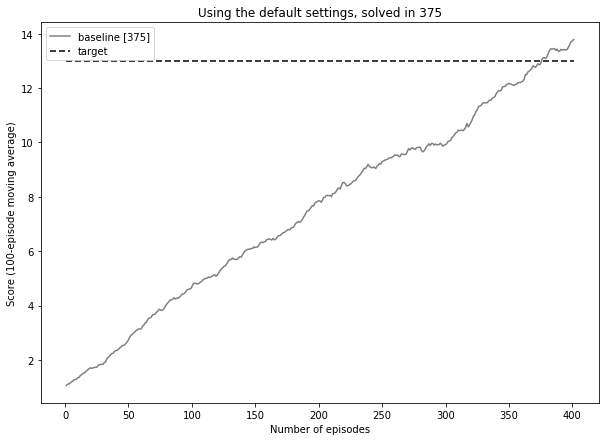

In [12]:
t = 'Using the default settings, solved in {}'.format(baseline_info['solved_in'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))

ax.plot(n_episodes, baseline_scores, label='baseline [{}]'.format(baseline_info['solved_in']), color='grey')
ax.plot(n_episodes, target_score, label='target', color='black', dashes=[4, 2])

plt.ylabel('Score (100-episode moving average)')
plt.xlabel('Number of episodes')
plt.title(t)
plt.legend()

Using the default parameters, the agent was able to achieve a 100-episode average score of >= 13.00 in 375 episodes.

### Altering epsilon decay

In [13]:
mask = (summary_data['eps_start'] == 1.0) & (summary_data['eps_end'] == 0.01) & (summary_data['update_every'] == 4)
epsilon_decay_runs = summary_data[mask].sort_values(by='eps_decay', ascending=True)
epsilon_ids = epsilon_decay_runs['id'].unique()

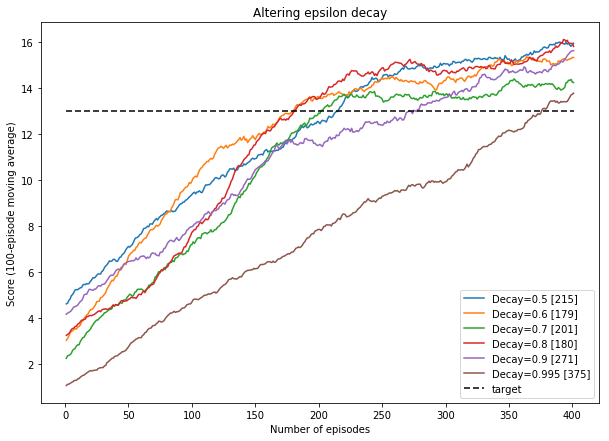

In [14]:
t = 'Altering epsilon decay'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))

for e_id in epsilon_ids:
    score_data = average_scores[e_id]
    decay_value = epsilon_decay_runs[epsilon_decay_runs['id'] == e_id]['eps_decay'].values[0]
    solved_value = epsilon_decay_runs[epsilon_decay_runs['id'] == e_id]['solved_in'].values[0]
    ax.plot(n_episodes, score_data, label='Decay={} [{}]'.format(decay_value, solved_value))

ax.plot(n_episodes, target_score, label='target', color='black', dashes=[4, 2])

plt.ylabel('Score (100-episode moving average)')
plt.xlabel('Number of episodes')
plt.title(t)
plt.legend()

A reduced the epsilon decay parameter (allowing the agent to converge towards exploitation strategies vs exploration strategies at a quicker rate) saw all strategies outperform the benchmark.

The benchmark improved in a relatively linear fashion, while altering epsilon decay allowed the agents to learn at a much faster rate. This is particularly noticable in the early episodes, where the average scores improved at a much faster rate than in the benchmark before tailing off as they approached scores around 13.

An epsilon decay value of 0.6 resulted in the agent solving the environment in 179 episodes. A value of 0.8 also achieved a score of 13 after 180 episodes. Comparing the two scores over time, the 0.8 decay was initially much slower than the 0.6 decay run, but after around 50 episodes the score began to rise steeply and eventually converged with the other run at around 150 episodes.

### Altering the update frequency

In [15]:
mask = (summary_data['eps_start'] == 1.0) & (summary_data['eps_end'] == 0.01) & (summary_data['eps_decay'] == 0.995)
subset = summary_data[mask].sort_values(by='update_every', ascending=True)

In [16]:
subset

,batch_size,buffer_size,eps_decay,eps_end,eps_start,gamma,id,lr,max_t,n_episodes,solved_in,tau,timestamp,update_every
9,64,100000,0.995,0.01,1.0,0.99,9,0.0005,1000,500,0,0.001,201832211032,1
6,64,100000,0.995,0.01,1.0,0.99,6,0.0005,1000,500,0,0.001,201820211020,2
0,64,100000,0.995,0.01,1.0,0.99,0,0.0005,1000,500,0,0.001,201807211007,3
14,64,100000,0.995,0.01,1.0,0.99,14,0.0005,1000,500,375,0.001,201858210958,4
13,64,100000,0.995,0.01,1.0,0.99,13,0.0005,1000,500,395,0.001,201850210950,5


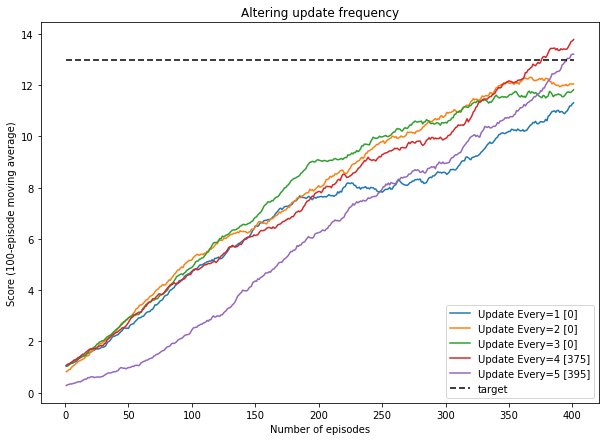

In [17]:
subset_ids = subset['id'].unique()

t = 'Altering update frequency'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))

for e_id in subset_ids:
    score_data = average_scores[e_id]
    param_value = subset[subset['id'] == e_id]['update_every'].values[0]
    solved_value = subset[subset['id'] == e_id]['solved_in'].values[0]
    ax.plot(n_episodes, score_data, label='Update Every={} [{}]'.format(param_value, solved_value))

ax.plot(n_episodes, target_score, label='target', color='black', dashes=[4, 2])

plt.ylabel('Score (100-episode moving average)')
plt.xlabel('Number of episodes')
plt.title(t)
plt.legend()

Using the default parameters and only changing the frequency in which the weights are updated had an adverse impact on the agent's ability to learn an optimal policy.  

With an update frequency of 1, 2 or 3, the agents were unable to solve the environment in the time frame, though it is interesting that all average score lines for these are on a par with the default update frequency of 4, but performance tails off markedly after 200 episodes for update=1, and after 300 episodes for updates 2 & 3.

### Altering starting epsilon

Lastly, I wanted to try altering the starting epsilon value. The default is 1.0 meaning that the agent initially favours experimentation exclusively. But given that the task is not overly complex, I thought that maybe I would see improvements if I set the agent to favour exploitation a little bit more initially.

In [18]:
mask = (summary_data['eps_end'] == 0.01) & (summary_data['eps_decay'] == 0.995) & (summary_data['update_every'] == 4)
subset = summary_data[mask].sort_values(by='eps_start', ascending=True)

In [19]:
subset

,batch_size,buffer_size,eps_decay,eps_end,eps_start,gamma,id,lr,max_t,n_episodes,solved_in,tau,timestamp,update_every
3,64,100000,0.995,0.01,0.6,0.99,3,0.0005,1000,500,312,0.001,201813221113,4
11,64,100000,0.995,0.01,0.7,0.99,11,0.0005,1000,500,372,0.001,201844221044,4
8,64,100000,0.995,0.01,0.8,0.99,8,0.0005,1000,500,388,0.001,201830221030,4
5,64,100000,0.995,0.01,0.9,0.99,5,0.0005,1000,500,381,0.001,201817221017,4
14,64,100000,0.995,0.01,1.0,0.99,14,0.0005,1000,500,375,0.001,201858210958,4


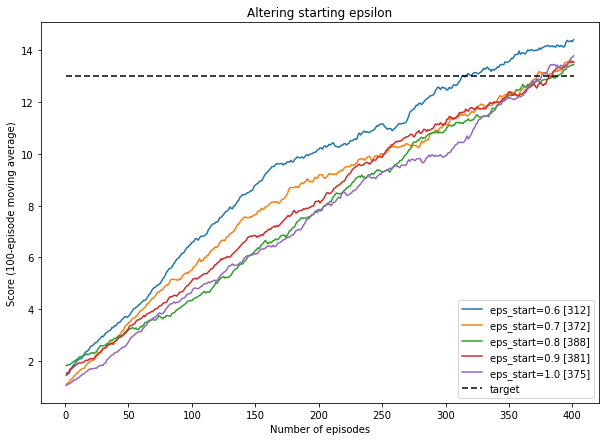

In [20]:
subset_ids = subset['id'].unique()

t = 'Altering starting epsilon'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))

for e_id in subset_ids:
    score_data = average_scores[e_id]
    param_value = subset[subset['id'] == e_id]['eps_start'].values[0]
    solved_value = subset[subset['id'] == e_id]['solved_in'].values[0]
    ax.plot(n_episodes, score_data, label='eps_start={} [{}]'.format(param_value, solved_value))

ax.plot(n_episodes, target_score, label='target', color='black', dashes=[4, 2])

plt.ylabel('Score (100-episode moving average)')
plt.xlabel('Number of episodes')
plt.title(t)
plt.legend()

Lowering the starting epsilon clearly improves the times taken to solve the environment. A starting value of 0.6 achieved the best performance, solving the environment in 312 episodes.

While these are improvements, they are still slower than the strategies of reducing the epsilon decay parameter.

### Altering multiple paramaters

In [21]:
optimal = summary_data[summary_data['timestamp'] == '201810221622']
optimal_id = optimal['id'].values[0]

In [22]:
optimal

,batch_size,buffer_size,eps_decay,eps_end,eps_start,gamma,id,lr,max_t,n_episodes,solved_in,tau,timestamp,update_every
2,64,100000,0.6,0.01,1.0,0.99,2,0.0005,1000,500,140,0.001,201810221622,3


In [23]:
optimal_scores = average_scores[optimal_id]
optimal_solved_in = optimal_id = optimal['solved_in'].values[0]

As it only took a few minutes to run each time, I tried a handful of combinations and the best performance I was able to achieve was to lower eps_decay to 0.6 and reduce update_every to 3. I left eps_start at the default 1.0 and did not attempt to change gamma, the learning rate or tau.

Using these optimal parameters the agent was able to solve the environment after 140 episodes.

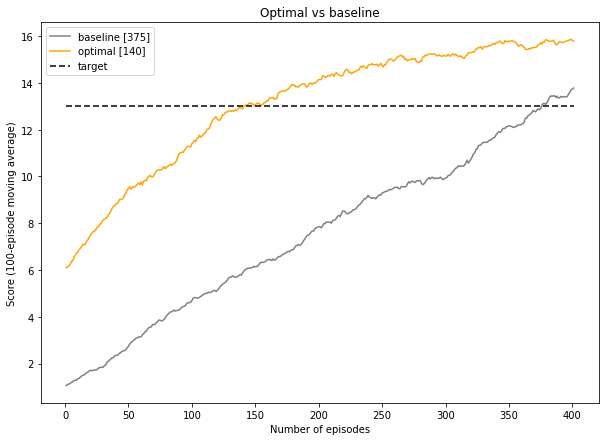

In [24]:
t = 'Optimal vs baseline'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))

ax.plot(n_episodes, baseline_scores, label='baseline [{}]'.format(baseline_info['solved_in']), color='grey')
ax.plot(n_episodes, optimal_scores, label='optimal [{}]'.format(optimal_solved_in), color='orange')
ax.plot(n_episodes, target_score, label='target', color='black', dashes=[4, 2])

plt.ylabel('Score (100-episode moving average)')
plt.xlabel('Number of episodes')
plt.title(t)
plt.legend()

### Future improvements

While the Deep-Q Network learning algorithm performed well on this task, it is known to have a tendency to overestimate action values. The algorithm could be improved upon by trying the following:

- Double DQN (helps address the overestimating of action values by the DQN)
- Prioritized Experience Replay (instead of sampling uniformly, by giving some experiences a higher probabilty of being sampled)
- Dueling DQN (a dueling algorithm is able to assess the value of each state, without the need to learn the effect of each action)